**Mounting to Google Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import All Required Packages**

In [2]:
import csv
import pandas as pd
import numpy as np
# used for encoding
import chardet
# natural language toolkit
import nltk
# wordnet is the database of English language
nltk.download('wordnet')
# stopwords for removing it from review
from nltk.corpus import stopwords
nltk.download('stopwords')
# to break tokens in to its root form
from nltk.stem import WordNetLemmatizer
# ngrams used for bigram input
from nltk.util import ngrams
import string
import math
# importing Linear SVM Classifier 
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
# evaluation measures
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
# for plots and visualizations
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**UNIVERSAL VARIABLE DECLARATION**

In [0]:
#universal variable declaration
dataset = []

# variable declaration for only review as the feature input
trainData = []
testData = []
trainData_label = []
testData_label = []

# variable declaration for All the feature input
trainDataAll = []
testDataAll = []
trainData_labelAll = []
testData_labelAll = []

# for removal of punctuation words
table = str.maketrans({key: None for key in string.punctuation})

# Label lists
label = []
labelAll = []

tfs = {}      # term frequency
tfidf = {}    # term frequency Inverse document frequency

tfs_test = {}    # term frequency for test data
tfidf_test = {}  # term frequency Inverse document frequency for test data

featureDict = {}         # A global dictionary of features
featureDict_test = {}    # A global dictionary of All features

**IMPORT DATASET  **

In [4]:
df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/amazon_data.csv", encoding='Latin-1')
df = df.sample(frac=1).reset_index(drop=True)

# Replace the Labels with FAKE and REAL
df = df.replace({'LABEL': {'__label1__':'FAKE' , '__label2__':'REAL'}})

display(df.head())

# label list for Review only
label=df['LABEL'].tolist()

# label list for all as feature
labelAll=df['LABEL'].tolist()



,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,10624,REAL,1,Y,Automotive,B005JU5VH8,"Bosch 22A ICON Wiper Blade - 22"" (Pack of 1)",Does not work on the passenger side of 2003 Ex...,"This might be a good blade on another vehicle,..."
1,7531,FAKE,5,N,Toys,B009MDU3CG,World Tech Toys 3.5CH Gyro Hercules Unbreakabl...,Awesome gift,I bought this for my 10 year old son and he ab...
2,13947,REAL,5,Y,Video Games,B003QPEKHA,Sesame Street: Cookie's Counting Carnival - Ni...,My son,My son loves this item. He goes on it everyday...
3,14256,REAL,5,Y,Books,615490646,Safe and Sound in the Hospital : Must-Have Che...,a must have !,Its a must have source of info for everyone. ...
4,6815,FAKE,5,N,Lawn and Garden,B00O97CPIK,Rid Tech Ultrasonic Pest Repeller - Repels Rod...,for $16 it's a steal,My family had spent hundreds of $$$ on pest c...


**DROPPING THE LABEL COLUMN**

In [0]:
# Drop the LABEL
df=df.drop('LABEL',axis=1)
row,col = df.shape


**TAKING INPUT FROM DATAFRAME TO LIST FORM**

In [0]:
dataset=list(df.values)


**VISUALIZATION OF WORD CLOUD**

**VISUALIZATION OF DATASET**

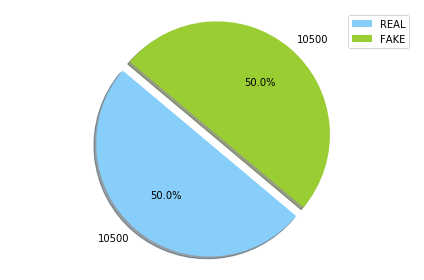

In [7]:
count_real=0
count_fake=0
for x in label:
  if x == 'REAL':
    count_real +=1
  else:
    count_fake +=1

count_rf=[count_real,count_fake] 
# Data to plot
labelss = 'REAL', 'FAKE'
labelss1=count_real,count_fake

colors = ['lightskyblue','yellowgreen']
explode = (0.1, 0)  # explode 1st slice
 

plt.pie(count_rf, explode=explode, labels=labelss1, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.legend(labelss)
plt.tight_layout()
plt.show()

**PARSE DATASET AND EXTRACT ESSENTIAL FEATURES FROM IT**


**Function for Parsing Only Review Text**

In [0]:
def parse(review):
    return (review[7])


**Function for Parsing Rating, Verified Purchase, Product Category, Review Title and Review Text **

In [0]:
def parseAll(review):
  return (review[1],review[2],review[3],review[6],review[7])

**TEXT PREPROCESSING**

***1. STOP WORDS REMOVAL***
***2. REMOVING PUNCTUATIONS***
***3. LEMMATIZING***

In [0]:
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    filtered_tokens=[]
    lemmatized_tokens = []
    stop_words = set(stopwords.words('english'))
    text = text.translate(table)           # translation of text is done here punctuations are replaced with none
    for w in text.split(" "):
        if w not in stop_words:
            lemmatized_tokens.append(lemmatizer.lemmatize(w.lower()))
      
    return lemmatized_tokens #lemmatized_tokens  #filtered_tokens
    

**COUNT OF TOKENS IN THE TEXT**

In [0]:
def bow(Text):
  
    bowCount = len(Text)
    
    return bowCount

**FUNCTION COMPUTING TERM FREQUENCY TF FOR EACH DOCUMENT**

In [0]:
def computeTF(localDict, bowCount):
    
    tfDict = {}
    for word, count in localDict.items():
        tfDict[word] = count/float(bowCount)
    
    return tfDict
    

**FUNCTION FOR COMPUTING THE INVERSE-DOCUMENT FREQUENCY IDF WITH RESPECT TO WHOLE DATA WHICH IS PASSED**

In [0]:
def computeIDF(docList):
   
    idfDict = {}
    #print(docList)
    N = row ## row
    #display(N)
    
    idfDict = dict.fromkeys(docList[0].keys(), 0)
    for doc in docList:
      for key, value in doc.items():
        
        if value > 0:
          idfDict[key] += 1
              #print(idfDict)
   
    for word, val in idfDict.items():
      idfDict[word] = math.log10(N / float(val))
   
    return idfDict

**FUNCTION FOR COMPUTING THE TERM FREQUENCY INVERSE-DOCUMENT FREQUENCY TF-IDF FOR EACH DOCUMENT**

In [0]:
# FOR TRAINING DATASET

def TFIDF(tfs, idfs): 
    
  for key,val in tfs.items():
    t={}
    for k,v in val.items():
       t[k]=v*idfs[k]
    tfidf[key] = t
     
  return tfidf

# FOR TEST DATASET
  
def TFIDF_test(tfs_test, idfs_t): 
  
  for key,val in tfs_test.items():
    t1={}
    for k,v in val.items():
       t1[k]=v*idfs_t[k]
    tfidf_test[key] = t1
    
  return tfidf_test
  
  

**FUNCTION FOR CONVERTING IN TO VECTOR**

In [0]:
# FOR TRAINING DATASET

def toFeatureVector(tokens):
    localDict = {}
    for token in tokens:
        if token not in featureDict:
            featureDict[token] = 1
        else:
            featureDict[token] += 1
   
        if token not in localDict:
            localDict[token] = 1
        else:
            localDict[token] += 1
        
    return localDict
  
# FOR TEST DATASET

def toFeatureVector_test(tokens1):
    localDict1 = {}
    for token1 in tokens1:
        if token1 not in featureDict_test:
            featureDict_test[token1] = 1
        else:
            featureDict_test[token1] += 1
   
        if token1 not in localDict1:
            localDict1[token1] = 1
        else:
            localDict1[token1] += 1
    
    return localDict1

**FUNCTION CALLED FOR  COMPUTING TF-IDF VLAUE FOR DOCUMENTS**

In [0]:
# FOR TRAINING DATASET

def tfidf_compute(dataset1):
  length=len(dataset1)
  for i in range(length):
      Text = parse(dataset1[i])
      temp={}
      temp={i:computeTF(toFeatureVector(preprocess(Text)),bow(preprocess(Text)))}
      tfs.update(temp)

  idfs = computeIDF([featureDict])
  tfidfs = TFIDF(tfs, idfs)
  return tfidfs

# FOR TEST DATASET

def tfidf_compute_test(dataset2):
  length1=len(dataset2)
  for j in range(length1):
      Text1 = parse(dataset2[j])
      temp1={}
      temp1={j:computeTF(toFeatureVector_test(preprocess(Text1)),bow(preprocess(Text1)))}
      tfs_test.update(temp1)

  idfs_t = computeIDF([featureDict_test])
  tfidfs_test = TFIDF_test(tfs_test, idfs_t)
  return tfidfs_test



**FUNCTION CALLED FOR  COMPUTING TF-IDF VLAUE FOR DOCUMENTS WITH ALL TAKEN AS FEATURES**

In [0]:
# FOR TRAINING DATASET

def tfidf_computeAll(dataset1):
  length=len(dataset1)
  for i in range(length):
      R,VP,PC,Title,Text = parseAll(dataset1[i])
      temp={}
      temp={i:computeTF(toFeatureVector(preprocess(f'{R} {VP} {PC} {Title} {Text}')),bow(preprocess(f'{R} {VP} {PC} {Title} {Text}')))}
      tfs.update(temp)

  idfs = computeIDF([featureDict])
  tfidfs = TFIDF(tfs, idfs)
  return tfidfs

# FOR TEST DATASET

def tfidf_compute_testAll(dataset2):
  length1=len(dataset2)
  for j in range(length1):
      R,VP,PC,Title,Text = parseAll(dataset2[j])
      temp1={}
      temp1={j:computeTF(toFeatureVector_test(preprocess(f'{R} {VP} {PC} {Title} {Text}')),bow(preprocess(f'{R} {VP} {PC} {Title} {Text}')))}
      tfs_test.update(temp1)

  idfs_t = computeIDF([featureDict_test])
  tfidfs_test = TFIDF_test(tfs_test, idfs_t)
  return tfidfs_test

**SPLITTING DATASET INTO DESIRED PERCENTAGE OF TRAIN AND TEST DATASET**

In [0]:

def split(percent):
    dataSamples = len(dataset)
    halfOfData = int(len(dataset)/2)
    trainingSamples = int((percent*dataSamples)/2)
    
    # TRAIN data here
  
    x1=dataset[:trainingSamples] + dataset[halfOfData:halfOfData+trainingSamples]
    # calling tfidf_compute
    train_tfidf = tfidf_compute(x1)
  
    for m,n in train_tfidf.items():
      # appending tfidf value (n) to the documents into trainData which is a list
      trainData.append((n))
    
   
    for x in label[:trainingSamples]+label[halfOfData:halfOfData+trainingSamples]:
      # appending Labels of data in to another list 
      trainData_label.append(x)
    
    # TEST data here
    
    x2=dataset[trainingSamples:halfOfData] + dataset[halfOfData+trainingSamples:]
    test_tfidf = tfidf_compute_test(x2)
    
   
    for m_t,n_t in test_tfidf.items():
      testData.append((n_t))
    
   
    for y in label[trainingSamples:halfOfData] + label[halfOfData+trainingSamples:]:
      testData_label.append(y)
    

**SPLITTING DATASET IN TO TRAIN AND TEST DATASET FOR ALL THE FEATURES** 

In [0]:
def splitAll(percent):
  
    dataSamplesAll = len(dataset)
    halfOfDataAll = int(len(dataset)/2)
    trainingSamplesAll = int((percent*dataSamplesAll)/2)
    
    # TRAIN Data here  
  
    x11 = dataset[:trainingSamplesAll] + dataset[halfOfDataAll:halfOfDataAll+trainingSamplesAll]
    train_tfidf = tfidf_computeAll(x11)
    for m11,n11 in train_tfidf.items():
      trainDataAll.append((n11))
    
   
    for x in labelAll[:trainingSamplesAll]+labelAll[halfOfDataAll:halfOfDataAll+trainingSamplesAll]:
      trainData_labelAll.append(x)
    
    # TEST Data here
    
    x22 = dataset[trainingSamplesAll:halfOfDataAll] + dataset[halfOfDataAll+trainingSamplesAll:]
    test_tfidf = tfidf_compute_testAll(x22)
    
   
    for m_t11,n_t11 in test_tfidf.items():
      testDataAll.append((n_t11))
    
   
    for y in labelAll[trainingSamplesAll:halfOfDataAll] + labelAll[halfOfDataAll+trainingSamplesAll:]:
      testData_labelAll.append(y)
    

**TRAINING CLASSIFIER FUNCTION USING LINEAR SVM**

In [0]:
def trainClassifier(trainclassifier):
  
    print("Training Classifier")
    pipeline =  Pipeline([('svc', LinearSVC())])
    
    return SklearnClassifier(pipeline).train(trainclassifier)

**CROSS-VALIDATE FUNCTION **

In [0]:
def crossValidate(dataset_cv, folds):
  
    cv_results = []
    
    # Each fold's Size of the dataset
    
    foldSize = int(len(dataset_cv)/folds)
    
    for i in range(0,len(dataset_cv),foldSize):
      
        # Training classifier for each foldsize traing set
        classifier = trainClassifier(dataset_cv[:i]+dataset_cv[foldSize+i:])
        
        # Predicting for the specified test set for the foldsize
        y_pred = predictLabels(dataset_cv[i:i+foldSize],classifier)
        
        # Measuring accuracy for test set
        a = accuracy_score(list(map(lambda d : d[1], dataset_cv[i:i+foldSize])), y_pred)
        
        # Measuring Precision ,Recall, F1-Score 
        (p,r,f,_) = precision_recall_fscore_support(list(map(lambda d : d[1], dataset_cv[i:i+foldSize])), y_pred, average ='macro')
        cv_results.append((a,p,r,f))
    cv_results = (np.mean(np.array(cv_results),axis=0))
    return cv_results

**FUNCTION FOR PREDICTING LABELS FOR TEST SET**

In [0]:
def predictLabels(reviewSamples, classifier1):
  
    # in-line function to map featue to classifier
    # Only keeping the features and not taking the labels to the classifier
    # t[0]
    
    return classifier1.classify_many(map(lambda t: t[0], reviewSamples))

**SPLIT FUNCTION IS CALLED FOR ONLY REVIEW AS FEATURE**

In [0]:
split(0.80)

## Make sure to input same portion of data in both the split as some function and data are shared by both ##

**TRAIN DATA AND TEST DATA **

In [0]:
# np.c_ is used to take both data and label as input together

TRAIN_MAIN_DATA = np.c_[trainData,trainData_label]
TEST_MAIN_DATA = np.c_[testData,testData_label]

# converting train and test set in to list form as desired input to classifier is in list form

TRAIN_MAIN_DATA = TRAIN_MAIN_DATA.tolist()
TEST_MAIN_DATA = TEST_MAIN_DATA.tolist()


**CROSS-VALIDATE CALLED FOR ONLY REVIEW AS A FEATURE**

In [25]:
print("Mean of cross-validations (Accuracy, Precision, Recall, Fscore): ", crossValidate(TRAIN_MAIN_DATA, 10))

Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Mean of cross-validations (Accuracy, Precision, Recall, Fscore):  [0.67386905 0.67379753 0.6738423  0.67372366]


**TESTING ACCURACY FOR ONLY REVIEW AS FEATURES **

In [26]:
## Test Accuracy
classifier = trainClassifier(TRAIN_MAIN_DATA)
predictions = predictLabels(TEST_MAIN_DATA, classifier)
true_labels = list(map(lambda d: d[1], TEST_MAIN_DATA))
a = accuracy_score(true_labels, predictions)
p, r, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
print("accuracy: ", a)
print("Precision: ", p)
print("Recall: ", r)
print("f1-score: ", f1)

Training Classifier
accuracy:  0.6776190476190476
Precision:  0.6775786440426594
Recall:  0.677596364569109
f1-score:  0.6775836622432032


**SPLIT FUNCTION CALLED FOR ALL AS FEATURE**

In [0]:
splitAll(0.80)


**TRAIN AND TEST FOR ALL FEATURE **

In [0]:
# np.c_ is used to concatenate data and label as input together for classifier


TRAIN_MAIN_DATA_All=np.c_[trainDataAll,trainData_labelAll]
TEST_MAIN_DATA_All=np.c_[testDataAll,testData_labelAll]

# converting train and test set in to list form as desired input to classifier is in list form

TRAIN_MAIN_DATA_All=TRAIN_MAIN_DATA_All.tolist()
TEST_MAIN_DATA_All=TEST_MAIN_DATA_All.tolist()

**CROSS-VALIDATE CALLED FOR ALL AS FEATURE**

In [29]:
CV_RES = crossValidate(TRAIN_MAIN_DATA_All, 10)
print("Mean of cross-validations (Accuracy, Precision, Recall, Fscore): ",CV_RES )

Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Mean of cross-validations (Accuracy, Precision, Recall, Fscore):  [0.81767857 0.81926408 0.8175777  0.81731751]


**VISUALIZATION OF CROSS-VALIDATION WITH 10 FOLDS**

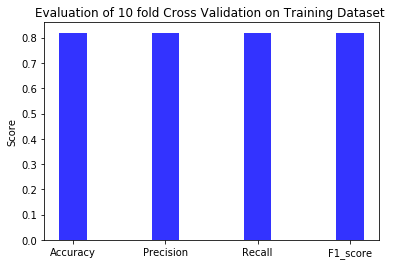

In [30]:
objects = ('Accuracy', 'Precision', 'Recall', 'F1_score')

performance = CV_RES
bar_width=0.3
rects1 = plt.bar(objects, performance,bar_width ,alpha=0.8,color='b',)
 
plt.xticks(objects, objects)
plt.ylabel('Score')
plt.title('Evaluation of 10 fold Cross Validation on Training Dataset ')


plt.show()

**TESTING ACCURACY FOR ALL FEATURES **

In [31]:
## Test Accuracy
classifier_All = trainClassifier(TRAIN_MAIN_DATA_All)
predictions_All = predictLabels(TEST_MAIN_DATA_All, classifier_All)
true_labels_All = list(map(lambda d: d[1], TEST_MAIN_DATA_All))
a_All = accuracy_score(true_labels_All, predictions_All)
p_All, r_All, f1_All, _ = precision_recall_fscore_support(true_labels_All, predictions_All, average='macro')
print("accuracy: ", a_All)
print("Precision: ", p_All)
print("Recall: ", r_All)
print("f1-score: ", f1_All)



#predi = classifier_All.predictLabels(TEST_MAIN_DATA_All)

#print('ROC-AUC yields ' + str(roc_auc_score(true_labels_All, predi[:,1])))
TEST_RES = [a_All,p_All,r_All,f1_All]

Training Classifier
accuracy:  0.8211904761904761
Precision:  0.8226529174656596
Recall:  0.8216171108557401
f1-score:  0.8210989465982453


**VISUALIZATION OF PREDICTION RESULT ON TEST DATA SET**

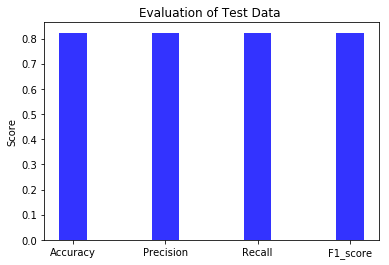

In [32]:
objects = ('Accuracy', 'Precision', 'Recall', 'F1_score')

performance = TEST_RES
bar_width=0.3
rects1 = plt.bar(objects, performance,bar_width ,alpha=0.8,color='b',)
 

plt.xticks(objects, objects)
plt.ylabel('Score')
plt.title('Evaluation of Test Data ')


plt.show()

**VISUALIZATION OF WORD CLOUD**

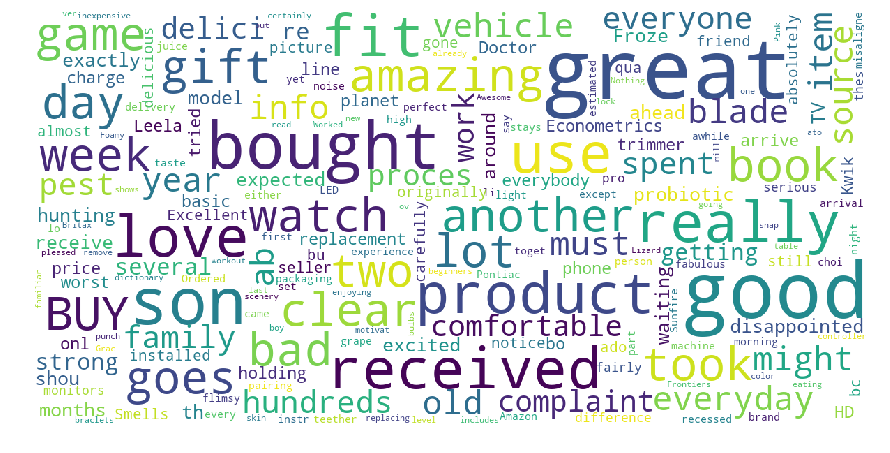

In [34]:
# word cloud Creation
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data1, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data1))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['REVIEW_TEXT'])